<h1> CV project - SIFT extraction


In [ ]:
# Clone the Hierarchical-Localization repository
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd Hierarchical-Localization
!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly
# Install the cloned repository
!pip install -e .

# Import necessary modules from the hloc package
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

/content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Obtaining file:///content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cvg/LightGlue to /tmp/pip-install-8wh04gjk/lightglue_b6aadd18532a4f19adba7df8f0ee54c5
  Running command git clone --filter=blob:none --quiet https://github.com/cvg/LightGlue /tmp/pip-install-8wh04gjk/lightglue_b6aadd18532a4f19adba7df8f0ee54c5
  Resolved https://github.com/cvg/LightGlue to commit edb2b838efb2ecfe3f88097c5fad9887d95aedad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: hloc
    Found existing installation: hloc 1.5
    Uninstalling hloc-1.5:
      Successfully uninstalled hloc-1.5
  Running setup.py develop for hloc


In [ ]:
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm
from pathlib import Path

## Monument - sacre coeur - SIFT

In [ ]:
images = Path('/content/Hierarchical-Localization/datasets/sacre_coeur')
outputs = Path('./outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['sift']
matcher_conf = match_features.confs['disk+lightglue']

printing the daytime images of sacre coeur

10 mapping images


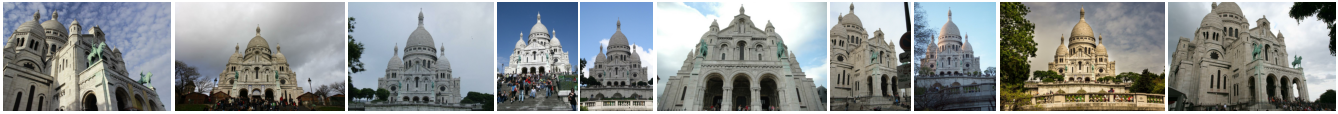

In [ ]:
references = [str(p.relative_to(images)) for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval.

In [ ]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/04/28 11:07:41 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'dog'},
 'output': 'feats-sift',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
[2024/04/28 11:07:50 hloc INFO] Finished exporting features.
[2024/04/28 11:07:50 hloc INFO] Found 45 pairs.
[2024/04/28 11:07:50 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /root/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 110MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Plea

Running incremental structure from motion

In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2024/04/26 07:22:12 hloc INFO] Creating an empty database...
[2024/04/26 07:22:12 hloc INFO] Importing images into the database...
[2024/04/26 07:22:12 hloc INFO] Importing features into the database...
100%|██████████| 10/10 [00:00<00:00, 592.17it/s]
[2024/04/26 07:22:12 hloc INFO] Importing matches into the database...
100%|██████████| 45/45 [00:00<00:00, 793.22it/s]
[2024/04/26 07:22:12 hloc INFO] Performing geometric verification of the matches...
[2024/04/26 07:22:25 hloc INFO] Running 3D reconstruction...
[2024/04/26 07:22:56 hloc INFO] Reconstructed 1 model(s).
[2024/04/26 07:22:56 hloc INFO] Largest model is #0 with 10 images.
[2024/04/26 07:22:56 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 5904
	num_observations = 31653
	mean_track_length = 5.36128
	mean_observations_per_image = 3165.3
	mean_reprojection_error = 0.844374
	num_input_images = 10


3D reconstructed model

In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()